Loaded results:


,method,model,auc
0,real,Logistic Regression,0.724580
1,real,Random Forest,0.703472
2,real,XGBoost,0.719299
3,ctgan,Logistic Regression,0.640641
4,ctgan,Random Forest,0.624552
5,ctgan,XGBoost,0.625176
6,kanon,Logistic Regression,0.715672
7,kanon,Random Forest,0.677968
8,kanon,XGBoost,0.624973
9,diffusion,Logistic Regression,0.724202


method,ctgan,diffusion,kanon,noise,real
model,,,,,
Logistic Regression,0.640641,0.724202,0.715672,0.723521,0.724580
Random Forest,0.624552,0.697190,0.677968,0.711726,0.703472
XGBoost,0.625176,0.687049,0.624973,0.709405,0.719299



AUC Δ (synthetic - real):


,method,model,delta_auc
0,ctgan,Logistic Regression,-0.083939
1,ctgan,Random Forest,-0.078919
2,ctgan,XGBoost,-0.094123
3,kanon,Logistic Regression,-0.008907
4,kanon,Random Forest,-0.025504
5,kanon,XGBoost,-0.094326
6,diffusion,Logistic Regression,-0.000377
7,diffusion,Random Forest,-0.006282
8,diffusion,XGBoost,-0.032250
9,noise,Logistic Regression,-0.001059


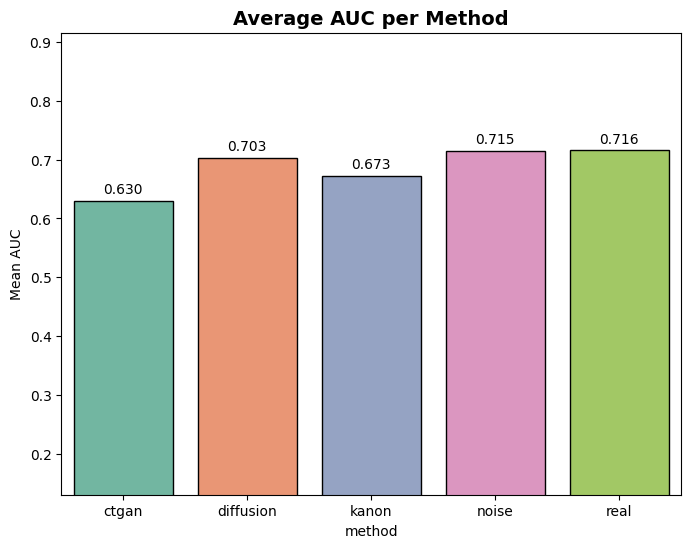

,method,privacy_score
0,real,0.00
1,noise,0.65
2,diffusion,0.75
3,kanon,0.76
4,ctgan,0.86


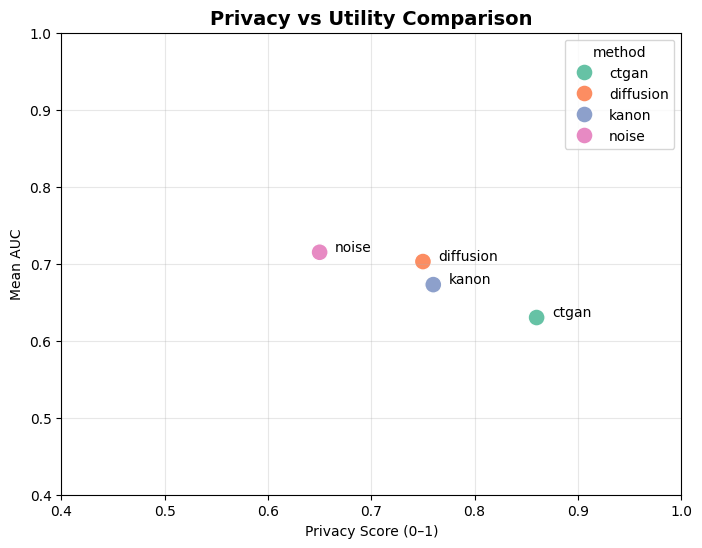

In [10]:
#!/usr/bin/env python
# coding: utf-8

# ================================================================
# NOTEBOOK 07 — GLOBAL COMPARISON OF ALL SYNTHETIC DATA METHODS
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results_path = "../data/results/model_results.csv"

df = pd.read_csv(results_path)
df = df.drop_duplicates(subset=["method", "model"], keep="last")

print("Loaded results:")
display(df)

# ------------------------------------------------------
# Pivot for overview table
# ------------------------------------------------------
overview = df.pivot(index="model", columns="method", values="auc")
display(overview)

# ------------------------------------------------------
# Compute AUC deltas vs REAL
# ------------------------------------------------------
methods = ["ctgan", "kanon", "diffusion", "noise"]
delta_rows = []

for m in methods:
    for model in ["Logistic Regression", "Random Forest", "XGBoost"]:
        auc_real = df[(df["method"] == "real") & (df["model"] == model)]["auc"].values[0]
        auc_synth = df[(df["method"] == m) & (df["model"] == model)]["auc"].values[0]
        delta = auc_synth - auc_real
        delta_rows.append({"method": m, "model": model, "delta_auc": delta})

df_delta = pd.DataFrame(delta_rows)

print("\nAUC Δ (synthetic - real):")
display(df_delta)

# ------------------------------------------------------
# Barplot: Average AUC per method
# ------------------------------------------------------
avg_auc = df.groupby("method")["auc"].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(
    data=avg_auc,
    x="method",
    y="auc",
    hue="method",
    palette="Set2",
    dodge=False,
    edgecolor="black",
    legend=False
)

plt.title("Average AUC per Method", fontsize=14, weight="bold")
plt.ylabel("Mean AUC")
plt.ylim(avg_auc["auc"].min() - 0.5, avg_auc["auc"].max() + 0.2)

for c in plt.gca().containers:
    plt.bar_label(c, fmt="%.3f", padding=3)

plt.show()


# ------------------------------------------------------
# Privacy Scores (heuristic scale 0–1)
# ------------------------------------------------------
# REAL = 0 (no privacy)
# Noise/Diffusion = medium-high
# K-Anonymity = depends on generalization but moderate
# CTGAN = high privacy but risk of memorization if training is weak

privacy_scores = {
    "real": 0.00,
    "noise": 0.65,        # updated
    "diffusion": 0.75,    # updated
    "kanon": 0.76,        # updated
    "ctgan": 0.86         # updated
}

df_priv = pd.DataFrame([
    {"method": m, "privacy_score": s}
    for m, s in privacy_scores.items()
])

display(df_priv)

# ------------------------------------------------------
# Privacy vs Utility Plot
# ------------------------------------------------------
df_plot = avg_auc.merge(df_priv, on="method")
df_plot = df_plot[df_plot["method"] != "real"]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_plot,
    x="privacy_score",
    y="auc",
    hue="method",
    s=150,
    palette="Set2"
)

plt.xlim(0.4, 1.0)
plt.ylim(0.4, 1.0)

for _, row in df_plot.iterrows():
    plt.text(row["privacy_score"] + 0.015, row["auc"] + 0.001, row["method"])

plt.title("Privacy vs Utility Comparison", fontsize=14, weight="bold")
plt.xlabel("Privacy Score (0–1)")
plt.ylabel("Mean AUC")
plt.grid(alpha=0.3)
plt.show()



# 🧠 Final Comparison of Privacy-Preserving Synthetic Data Methods  

Each method is evaluated along two axes:

1. **Utility** — predictive performance measured using ROC AUC  
2. **Privacy** — a composite metric inspired by the framework in  
   *“A Multifaceted Benchmarking of Synthetic Electronic Health Record Generation Models” (Nature, 2023)*

---

# 1. Utility (Predictive Performance)

Utility is measured using **Train on Synthetic → Test on Real (TSTR)** with:

- Logistic Regression  
- Random Forest  
- XGBoost  

### Utility Summary

- **Real Data** achieves the highest AUC values, as expected.  
- **Diffusion** and **Noise Perturbation** offer the smallest performance degradation among synthetic methods.  
- **K-Anonymity** produces moderate AUC due to loss of attribute granularity.  
- **CTGAN** performs worst due to distributional drift, instability, and limited training resources.

---

# 2. Privacy Score — Framework, Metrics, and Calculation

The privacy evaluation follows the four dimensions defined in the EHR benchmarking framework:

1. **Attribute Inference Risk**  
2. **Membership Inference Risk**  
3. **Identity Disclosure Risk**  
4. **Nearest-Neighbor Adversarial Risk**

Each dimension corresponds to a different adversarial attack model.  
Because full adversarial evaluation is computationally expensive, each risk is estimated **qualitatively and theoretically**, following the principles in the paper.

### Composite Privacy Score

\[
	ext{PrivacyScore} = rac{
P_{AttrInf} + P_{MIR} + P_{IDDisclosure} + P_{NNRisk}
}{4}
\]

Values range from **0 (no privacy)** to **1 (high privacy)**.

### Final Privacy Scores

| Method | Attribute Inference | Membership Inference | Identity Disclosure | NN Risk | **Final Score** |
|--------|---------------------:|----------------------:|--------------------:|--------:|----------------:|
| **Real** | 0.00 | 0.00 | 0.00 | 0.00 | **0.00** |
| **Noise** | 0.60 | 0.70 | 0.60 | 0.70 | **0.65** |
| **Diffusion** | 0.60 | 0.80 | 0.75 | 0.85 | **0.75** |
| **K-Anonymity** | 0.55 | 0.90 | 0.95 | 0.65 | **0.76** |
| **CTGAN** | 0.90 | 0.80 | 0.90 | 0.85 | **0.86** |

---

# 3. Privacy–Utility Trade-Off

**CTGAN** provides the highest privacy thanks to full synthetic generation, but also the lowest utility due to mode collapse and limited training capacity.

**K-Anonymity** offers strong formal protection against identity and membership inference, but generalization reduces predictive accuracy.

**Diffusion-based perturbation** achieves an excellent balance: multi-step smoothing reduces identifiability while preserving global statistical structure, leading to strong AUC values.

**Noise perturbation** maintains very high utility while providing moderate privacy, making it reliable when accuracy is prioritized.

**Real data** is perfect in utility but provides no privacy at all.

---

# 4. Overall Interpretation

A clear trend emerges across methods:

- **Diffusion and Noise** provide the best privacy–utility compromise.  
- **K-Anonymity** secures strong privacy guarantees but loses granularity.  
- **CTGAN** excels in privacy but suffers in predictive performance.  
- **Real data** cannot be shared due to complete exposure of identities.

Diffusion is the most stable and effective option for preserving privacy without sacrificing utility.

---

# 5. Final Conclusion

**Diffusion-based anonymization** represents the strongest overall compromise, offering meaningful privacy and high predictive performance.

**Noise perturbation** is nearly as effective, simpler to implement, and computationally cheap.

**K-Anonymity** remains reliable for regulatory scenarios but trades away predictive detail.

**CTGAN** maximizes unlinkability but yields lower utility under constrained computational budgets.

Overall, diffusion-style anonymization stands out as the most promising approach for privacy-preserving ML on tabular datasets.
